# TensorFlow Autoencodeur avec attention pour le PAr

## Setup

Moi j'ai installé tf addons par `pip install tensorflow-addons==0.13.0` (ET NON PAS `conda install -c esri tensorflow-addons`). Voir les compatibilités [sur le github de tensorflow_addons](https://github.com/tensorflow/addons).

In [1]:
# !pip install tensorflow-addons==0.11.2

In [2]:
import sys
print(sys.version)

3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:36:06) [MSC v.1929 64 bit (AMD64)]


In [3]:
import tensorflow as tf
import numpy as np
import io
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1


# Step 1: Get the data

In [5]:
path_reglement_scol  = 'corpus.txt'
path_questions_scol  = 'touteslesquestions.txt'

# Step 2: Preprocess the data

In [6]:
import re as regex
# acquisition du texte
#reglement_scol = io.open(path_reglement_scol, encoding='UTF-8').read()#.strip().split('\n')
questions_scol = io.open(path_questions_scol, encoding='UTF-8').read()#.strip().split('\n')
texte = questions_scol

On crée d'abord une liste de phrases dont chaque mot est séparé par un espace. On a besoin de `spacy` pour découper correctement les mots en français d'abord.

In [62]:
import nltk
import spacy
nlp = spacy.load('fr_core_news_sm')
#phrases = nltk.tokenize.sent_tokenize(texte, language='french')
phrases = texte.split('\n')[:-1]
print('phrases parsées par NLTK')
phrasesTokeniseesSpacy = [nlp(s) for s in phrases]
print('phrases tokénisées par spacy')
phrasesSpacy = [' '.join([token.text.lower() for token in doc]) for doc in phrasesTokeniseesSpacy]
print('phrases découpées en tokens puis refusionnées')

phrases parsées par NLTK
phrases tokénisées par spacy
phrases découpées en tokens puis refusionnées


On supprime les listes inutiles désormais

In [8]:
del phrasesTokeniseesSpacy

Créer un tokéniseur adapté à notre vocabulaire

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters='')
# créer un tokenizer adapté à tout le vocabulaire des phrases
tokenizer.fit_on_texts(phrasesSpacy)

Créer les tenseurs pour toutes les phrases et padder le tout

In [10]:
tensor_sentences = tokenizer.texts_to_sequences(phrasesSpacy)
print(type(tensor_sentences))
print(phrasesSpacy[0],tensor_sentences[0])
# enfin on padd le tout pour pouvoir l'utiliser dans un réseau de neurones
tensor_sentences = tf.keras.preprocessing.sequence.pad_sequences(tensor_sentences,padding='post')

<class 'list'>
qui approuve le règlement de scolarité ? [17, 252, 12, 152, 2, 370, 1]


In [11]:
# Fonction qui convertit un mot en son représentant entier
def convert(tokenizer, tensor):
    for t in tensor: # t est un entier élément du tenseur
        if t != 0:
            print ("%d ----> %s" % (t, tokenizer.index_word[t]))
convert(tokenizer, tensor_sentences[-1])

21 ----> comment
6 ----> la
29 ----> mobilité
116 ----> est-elle
705 ----> vérifiée
7 ----> pour
3 ----> les
64 ----> doubles
59 ----> diplômes
20 ----> en
61 ----> france
1 ----> ?


# Step 3: Define problem numbers

`tokenizer.index_word` est un dictionnaire dont les clés sont des entiers et les valeurs sont des struings (mots du vocabulaire)

In [12]:
print('tensor:')
print(type(tensor_sentences))
print(np.shape(tensor_sentences))
tensor_sentences[0]
print("tokenizer:")
print(type(tokenizer))
print(type(tokenizer.index_word))

vocab_inp_size = len(tokenizer.word_index)
n_data,max_length = tensor_sentences.shape
embedding_dim = 50

print(f"nombre de données: {n_data}\nlongueur max phrases en mots: {max_length}\ntaille du vocabulaire: {vocab_inp_size}\ndimension de l'embedding: {embedding_dim}")

tensor:
<class 'numpy.ndarray'>
(1570, 48)
tokenizer:
<class 'keras_preprocessing.text.Tokenizer'>
<class 'dict'>
nombre de données: 1570
longueur max phrases en mots: 48
taille du vocabulaire: 964
dimension de l'embedding: 50


# Step 4: Split the train and validation data

In [13]:
from sklearn.model_selection import train_test_split

# Create training and validation sets using an 80/20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(tensor_sentences, tensor_sentences, test_size=0.2)

print(type(input_tensor_train), type(target_tensor_train))
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

# on observe ce qu'il y a dans ces données: si on rééxécute ça change, c'est parce qu'il y a un shuffle aléatoire
convert(tokenizer, input_tensor_train[0])

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
1256 1256 314 314
3 ----> les
632 ----> motifs
2 ----> de
568 ----> refus
27 ----> du
146 ----> ceu
13 ----> sont
91 ----> -ils
633 ----> transmis
108 ----> aux
100 ----> étudiants
1 ----> ?


# Step 5: create Encoder and Decoder classes

In [14]:
# Encoder class
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units


        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)


        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x):
        x = self.embedding(x)
        output, state = self.gru(x)
        return output, state
        # hidden state shape == (batch_size, hidden size)
        # output       shape == (batch_size, max_len, hidden size)

In [15]:
# Decoder class
class Decoder(tf.keras.Model):
    def __init__(self, dec_units,max_length):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.attention = tf.keras.layers.Attention()
        self.dense = tf.keras.layers.Dense(1)
        self.reshape = tf.keras.layers.Reshape([max_length])

    def call(self, enc_output,enc_hidden):
        attention_outputs, attention_scores = tf.keras.layers.Attention()([enc_output, enc_hidden], return_attention_scores=True)
        context = attention_outputs * enc_output
        final_output = self.dense(context)
        final_output = self.reshape(final_output)
        return final_output

encoder = Encoder(vocab_inp_size, embedding_dim, 128)
decoder = Decoder(128,10)

enc_in = tf.random.uniform(
    (6,10),
    minval=0,
    maxval=60,
    dtype=tf.dtypes.int32,
    name="dummy_input_encoder"
)


print('Encoder Input        shape: (batch_size, timesteps)                {}'.format(enc_in.shape))
enc_output, enc_hidden = encoder(enc_in)

print('Encoder Output       shape: (batch_size, sequence_length, units)   {}'.format(enc_output.shape))
print('Encoder Hidden_state shape: (batch_size, units)                    {}'.format(enc_hidden.shape))

output = decoder(enc_output)

print(output.shape)

dec_out = decoder(enc_output)
dec_out.shape
#print('Attention output: (batch_size, sequence_length, units)', attention_outputs.shape)
#print('Attention scores: (batch_size, sequence_length, units)', attention_scores.shape)

In [16]:
class Autoencoder(tf.keras.Model):
    def __init__(self, embedding_dim, vocab_inp_size, max_length, latent_dim):
        super().__init__()

        self.latent_dim = 250
        self.encoder = Encoder(vocab_inp_size, embedding_dim, latent_dim)
        self.decoder = Decoder(latent_dim,max_length)

    def call(self, inputs):
        enc_output,enc_hidden = self.encoder(inputs)
        out_dec = self.decoder(enc_output,enc_hidden)
        return out_dec
    
    def vectoriser(self, phrase):
        l = tokenizer.texts_to_sequences([phrase])
        for ll in l:
            ll += (max_length-len(ll))*[0]
            
        return(self.encoder(np.asarray(l))[1][0])
        


In [17]:
latent_dim = 128
autoenc = Autoencoder(embedding_dim,vocab_inp_size,max_length,128)
autoenc.compile(optimizer='Adam', loss=tf.losses.MeanSquaredError(), metrics = ["accuracy"]) # losses.MeanSquaredError() losses.CosineSimilarity()
autoenc.build(input_shape=input_tensor_train.shape)


# input_tensor_train.shape, autoenc(input_tensor_train).shape # ne pas décommenter si gros gros tenseurs

In [18]:
history = autoenc.fit(input_tensor_train,target_tensor_train,
                epochs=1000,
                batch_size=64*4,
                shuffle=True,
                validation_data=(input_tensor_val,target_tensor_val),
                verbose=1)

Epoch 1/1000
5/5 [==============================] - 3s 201ms/step - loss: 9840.6133 - accuracy: 0.0000e+00 - val_loss: 9275.5625 - val_accuracy: 0.0000e+00
Epoch 2/1000
5/5 [==============================] - 0s 105ms/step - loss: 9839.8467 - accuracy: 0.0000e+00 - val_loss: 9274.0557 - val_accuracy: 0.0000e+00
Epoch 3/1000
5/5 [==============================] - 1s 107ms/step - loss: 9836.2334 - accuracy: 0.0000e+00 - val_loss: 9262.3516 - val_accuracy: 0.0000e+00
Epoch 4/1000
5/5 [==============================] - 1s 106ms/step - loss: 9806.0264 - accuracy: 0.0000e+00 - val_loss: 9197.6543 - val_accuracy: 0.0000e+00
Epoch 5/1000
5/5 [==============================] - 0s 95ms/step - loss: 9719.1797 - accuracy: 0.0088 - val_loss: 9094.2852 - val_accuracy: 0.0446
Epoch 6/1000
5/5 [==============================] - 0s 44ms/step - loss: 9611.3252 - accuracy: 0.0494 - val_loss: 8995.8896 - val_accuracy: 0.0796
Epoch 7/1000
5/5 [==============================] - 0s 43ms/step - loss: 9518.5273

5/5 [==============================] - 0s 50ms/step - loss: 8059.9492 - accuracy: 0.1584 - val_loss: 7534.7690 - val_accuracy: 0.1242
Epoch 57/1000
5/5 [==============================] - 0s 50ms/step - loss: 8037.1021 - accuracy: 0.1608 - val_loss: 7514.3457 - val_accuracy: 0.1274
Epoch 58/1000
5/5 [==============================] - 0s 50ms/step - loss: 8016.4126 - accuracy: 0.1608 - val_loss: 7494.5874 - val_accuracy: 0.1274
Epoch 59/1000
5/5 [==============================] - 0s 49ms/step - loss: 7994.8242 - accuracy: 0.1680 - val_loss: 7475.0850 - val_accuracy: 0.1338
Epoch 60/1000
5/5 [==============================] - 0s 50ms/step - loss: 7974.4429 - accuracy: 0.1720 - val_loss: 7455.1196 - val_accuracy: 0.1338
Epoch 61/1000
5/5 [==============================] - 0s 50ms/step - loss: 7953.4253 - accuracy: 0.1791 - val_loss: 7434.8916 - val_accuracy: 0.1401
Epoch 62/1000
5/5 [==============================] - 0s 50ms/step - loss: 7932.8486 - accuracy: 0.1863 - val_loss: 7415.9468 -

5/5 [==============================] - 0s 55ms/step - loss: 6949.2183 - accuracy: 0.3758 - val_loss: 6532.7002 - val_accuracy: 0.3567
Epoch 112/1000
5/5 [==============================] - 0s 56ms/step - loss: 6928.5103 - accuracy: 0.3782 - val_loss: 6516.5947 - val_accuracy: 0.3662
Epoch 113/1000
5/5 [==============================] - 0s 58ms/step - loss: 6908.7388 - accuracy: 0.3806 - val_loss: 6499.8062 - val_accuracy: 0.3694
Epoch 114/1000
5/5 [==============================] - 0s 58ms/step - loss: 6888.7764 - accuracy: 0.3861 - val_loss: 6482.2061 - val_accuracy: 0.3758
Epoch 115/1000
5/5 [==============================] - 0s 57ms/step - loss: 6866.7358 - accuracy: 0.3949 - val_loss: 6465.4771 - val_accuracy: 0.3758
Epoch 116/1000
5/5 [==============================] - 0s 57ms/step - loss: 6845.5635 - accuracy: 0.4005 - val_loss: 6448.5815 - val_accuracy: 0.3885
Epoch 117/1000
5/5 [==============================] - 0s 56ms/step - loss: 6821.2876 - accuracy: 0.4045 - val_loss: 6429.

5/5 [==============================] - 0s 54ms/step - loss: 5673.7246 - accuracy: 0.4164 - val_loss: 5648.0020 - val_accuracy: 0.4172
Epoch 167/1000
5/5 [==============================] - 0s 54ms/step - loss: 5625.3105 - accuracy: 0.4124 - val_loss: 5671.5488 - val_accuracy: 0.4013
Epoch 168/1000
5/5 [==============================] - 0s 54ms/step - loss: 5597.8921 - accuracy: 0.4100 - val_loss: 5669.7373 - val_accuracy: 0.3917
Epoch 169/1000
5/5 [==============================] - 0s 54ms/step - loss: 5571.4136 - accuracy: 0.4180 - val_loss: 5659.9702 - val_accuracy: 0.3885
Epoch 170/1000
5/5 [==============================] - 0s 56ms/step - loss: 5548.9448 - accuracy: 0.4252 - val_loss: 5644.9097 - val_accuracy: 0.4013
Epoch 171/1000
5/5 [==============================] - 0s 54ms/step - loss: 5525.6562 - accuracy: 0.4339 - val_loss: 5628.8232 - val_accuracy: 0.4172
Epoch 172/1000
5/5 [==============================] - 0s 55ms/step - loss: 5502.3740 - accuracy: 0.4299 - val_loss: 5613.

5/5 [==============================] - 0s 54ms/step - loss: 4690.1885 - accuracy: 0.4777 - val_loss: 4953.7173 - val_accuracy: 0.4459
Epoch 222/1000
5/5 [==============================] - 0s 53ms/step - loss: 4675.4688 - accuracy: 0.4769 - val_loss: 4941.2119 - val_accuracy: 0.4459
Epoch 223/1000
5/5 [==============================] - 0s 54ms/step - loss: 4657.4072 - accuracy: 0.4769 - val_loss: 4934.2993 - val_accuracy: 0.4395
Epoch 224/1000
5/5 [==============================] - 0s 54ms/step - loss: 4642.0552 - accuracy: 0.4745 - val_loss: 4930.4302 - val_accuracy: 0.4459
Epoch 225/1000
5/5 [==============================] - 0s 54ms/step - loss: 4714.4995 - accuracy: 0.4697 - val_loss: 4731.1475 - val_accuracy: 0.4713
Epoch 226/1000
5/5 [==============================] - 0s 54ms/step - loss: 4646.2144 - accuracy: 0.4944 - val_loss: 4751.0977 - val_accuracy: 0.4809
Epoch 227/1000
5/5 [==============================] - 0s 54ms/step - loss: 4637.5576 - accuracy: 0.4920 - val_loss: 4720.

5/5 [==============================] - 0s 54ms/step - loss: 3920.2751 - accuracy: 0.5581 - val_loss: 4417.4634 - val_accuracy: 0.5223
Epoch 277/1000
5/5 [==============================] - 0s 54ms/step - loss: 4042.9905 - accuracy: 0.5565 - val_loss: 4211.1411 - val_accuracy: 0.5191
Epoch 278/1000
5/5 [==============================] - 0s 55ms/step - loss: 4215.7231 - accuracy: 0.5613 - val_loss: 4938.8696 - val_accuracy: 0.5159
Epoch 279/1000
5/5 [==============================] - 0s 54ms/step - loss: 4547.1113 - accuracy: 0.5573 - val_loss: 4680.5596 - val_accuracy: 0.4968
Epoch 280/1000
5/5 [==============================] - 0s 55ms/step - loss: 4177.7827 - accuracy: 0.5549 - val_loss: 4323.8467 - val_accuracy: 0.5032
Epoch 281/1000
5/5 [==============================] - 0s 54ms/step - loss: 3988.9590 - accuracy: 0.5605 - val_loss: 4263.8896 - val_accuracy: 0.4968
Epoch 282/1000
5/5 [==============================] - 0s 55ms/step - loss: 3946.8882 - accuracy: 0.5645 - val_loss: 4557.

5/5 [==============================] - 0s 59ms/step - loss: 3361.0549 - accuracy: 0.6322 - val_loss: 3980.8523 - val_accuracy: 0.5732
Epoch 332/1000
5/5 [==============================] - 0s 58ms/step - loss: 3630.9893 - accuracy: 0.6266 - val_loss: 3977.8821 - val_accuracy: 0.5669
Epoch 333/1000
5/5 [==============================] - 0s 59ms/step - loss: 3361.5750 - accuracy: 0.6369 - val_loss: 3971.0652 - val_accuracy: 0.5637
Epoch 334/1000
5/5 [==============================] - 0s 60ms/step - loss: 3349.7551 - accuracy: 0.6330 - val_loss: 3970.3723 - val_accuracy: 0.5701
Epoch 335/1000
5/5 [==============================] - 0s 58ms/step - loss: 3336.5359 - accuracy: 0.6322 - val_loss: 3950.6047 - val_accuracy: 0.5701
Epoch 336/1000
5/5 [==============================] - 0s 59ms/step - loss: 3513.7935 - accuracy: 0.6282 - val_loss: 4155.2173 - val_accuracy: 0.5478
Epoch 337/1000
5/5 [==============================] - 0s 60ms/step - loss: 3536.7424 - accuracy: 0.6298 - val_loss: 3898.

5/5 [==============================] - 0s 55ms/step - loss: 3206.2039 - accuracy: 0.6568 - val_loss: 4149.1831 - val_accuracy: 0.5701
Epoch 387/1000
5/5 [==============================] - 0s 54ms/step - loss: 3135.2366 - accuracy: 0.6736 - val_loss: 3683.7891 - val_accuracy: 0.5764
Epoch 388/1000
5/5 [==============================] - 0s 55ms/step - loss: 2956.3250 - accuracy: 0.6791 - val_loss: 3547.8269 - val_accuracy: 0.5796
Epoch 389/1000
5/5 [==============================] - 0s 57ms/step - loss: 2930.8376 - accuracy: 0.6919 - val_loss: 3770.3623 - val_accuracy: 0.5987
Epoch 390/1000
5/5 [==============================] - 0s 56ms/step - loss: 3340.3101 - accuracy: 0.6791 - val_loss: 3758.7664 - val_accuracy: 0.6019
Epoch 391/1000
5/5 [==============================] - 0s 56ms/step - loss: 2901.2993 - accuracy: 0.6823 - val_loss: 3753.2947 - val_accuracy: 0.5987
Epoch 392/1000
5/5 [==============================] - 0s 56ms/step - loss: 2898.7747 - accuracy: 0.6831 - val_loss: 3744.

5/5 [==============================] - 0s 70ms/step - loss: 2530.8262 - accuracy: 0.7189 - val_loss: 3407.5132 - val_accuracy: 0.6338
Epoch 442/1000
5/5 [==============================] - 0s 68ms/step - loss: 2523.7349 - accuracy: 0.7189 - val_loss: 3406.5952 - val_accuracy: 0.6338
Epoch 443/1000
5/5 [==============================] - 0s 55ms/step - loss: 2516.6006 - accuracy: 0.7174 - val_loss: 3408.5286 - val_accuracy: 0.6369
Epoch 444/1000
5/5 [==============================] - 0s 54ms/step - loss: 2509.8420 - accuracy: 0.7189 - val_loss: 3408.2593 - val_accuracy: 0.6401
Epoch 445/1000
5/5 [==============================] - 0s 55ms/step - loss: 2502.7356 - accuracy: 0.7189 - val_loss: 3406.8821 - val_accuracy: 0.6401
Epoch 446/1000
5/5 [==============================] - 0s 55ms/step - loss: 2495.6772 - accuracy: 0.7189 - val_loss: 3404.4426 - val_accuracy: 0.6433
Epoch 447/1000
5/5 [==============================] - 0s 55ms/step - loss: 2487.4744 - accuracy: 0.7197 - val_loss: 3400.

5/5 [==============================] - 0s 55ms/step - loss: 2197.7571 - accuracy: 0.7412 - val_loss: 3157.6936 - val_accuracy: 0.6720
Epoch 497/1000
5/5 [==============================] - 0s 54ms/step - loss: 2189.7729 - accuracy: 0.7412 - val_loss: 3177.6836 - val_accuracy: 0.6656
Epoch 498/1000
5/5 [==============================] - 0s 56ms/step - loss: 2180.8406 - accuracy: 0.7412 - val_loss: 3179.3271 - val_accuracy: 0.6656
Epoch 499/1000
5/5 [==============================] - 0s 54ms/step - loss: 2172.1367 - accuracy: 0.7412 - val_loss: 3179.9358 - val_accuracy: 0.6656
Epoch 500/1000
5/5 [==============================] - 0s 55ms/step - loss: 2164.0942 - accuracy: 0.7420 - val_loss: 3179.3721 - val_accuracy: 0.6624
Epoch 501/1000
5/5 [==============================] - 0s 55ms/step - loss: 2157.5867 - accuracy: 0.7420 - val_loss: 3181.8389 - val_accuracy: 0.6624
Epoch 502/1000
5/5 [==============================] - 0s 58ms/step - loss: 2149.7480 - accuracy: 0.7428 - val_loss: 3185.

5/5 [==============================] - 0s 56ms/step - loss: 2175.6233 - accuracy: 0.7747 - val_loss: 3113.3374 - val_accuracy: 0.6911
Epoch 552/1000
5/5 [==============================] - 0s 56ms/step - loss: 1885.8997 - accuracy: 0.7699 - val_loss: 3062.0037 - val_accuracy: 0.6943
Epoch 553/1000
5/5 [==============================] - 0s 57ms/step - loss: 1893.8257 - accuracy: 0.7683 - val_loss: 3036.3450 - val_accuracy: 0.6847
Epoch 554/1000
5/5 [==============================] - 0s 56ms/step - loss: 2159.9846 - accuracy: 0.7659 - val_loss: 3001.7039 - val_accuracy: 0.7006
Epoch 555/1000
5/5 [==============================] - 0s 57ms/step - loss: 1893.3724 - accuracy: 0.7723 - val_loss: 2952.5437 - val_accuracy: 0.7006
Epoch 556/1000
5/5 [==============================] - 0s 56ms/step - loss: 2175.1880 - accuracy: 0.7627 - val_loss: 2883.1108 - val_accuracy: 0.6879
Epoch 557/1000
5/5 [==============================] - 0s 55ms/step - loss: 1915.6177 - accuracy: 0.7715 - val_loss: 2857.

5/5 [==============================] - 0s 55ms/step - loss: 1640.8915 - accuracy: 0.7866 - val_loss: 2916.6389 - val_accuracy: 0.6783
Epoch 607/1000
5/5 [==============================] - 0s 55ms/step - loss: 1638.7224 - accuracy: 0.7890 - val_loss: 2915.1299 - val_accuracy: 0.6847
Epoch 608/1000
5/5 [==============================] - 0s 55ms/step - loss: 1635.5865 - accuracy: 0.7890 - val_loss: 2916.1978 - val_accuracy: 0.6879
Epoch 609/1000
5/5 [==============================] - 0s 54ms/step - loss: 1631.0239 - accuracy: 0.7922 - val_loss: 2919.3154 - val_accuracy: 0.6879
Epoch 610/1000
5/5 [==============================] - 0s 54ms/step - loss: 1624.5270 - accuracy: 0.7938 - val_loss: 2920.4026 - val_accuracy: 0.6943
Epoch 611/1000
5/5 [==============================] - 0s 55ms/step - loss: 1617.2924 - accuracy: 0.7986 - val_loss: 2928.0410 - val_accuracy: 0.6911
Epoch 612/1000
5/5 [==============================] - 0s 54ms/step - loss: 1808.0902 - accuracy: 0.8010 - val_loss: 2921.

5/5 [==============================] - 0s 55ms/step - loss: 1603.1473 - accuracy: 0.8201 - val_loss: 2766.0859 - val_accuracy: 0.7293
Epoch 662/1000
5/5 [==============================] - 0s 56ms/step - loss: 1523.0973 - accuracy: 0.8256 - val_loss: 2706.1987 - val_accuracy: 0.7166
Epoch 663/1000
5/5 [==============================] - 0s 57ms/step - loss: 1483.4507 - accuracy: 0.8225 - val_loss: 2645.5813 - val_accuracy: 0.7134
Epoch 664/1000
5/5 [==============================] - 0s 58ms/step - loss: 1491.1274 - accuracy: 0.8185 - val_loss: 2717.2595 - val_accuracy: 0.7166
Epoch 665/1000
5/5 [==============================] - 0s 58ms/step - loss: 1477.7777 - accuracy: 0.8185 - val_loss: 2771.0876 - val_accuracy: 0.7006
Epoch 666/1000
5/5 [==============================] - 0s 59ms/step - loss: 1467.1272 - accuracy: 0.8177 - val_loss: 2804.2537 - val_accuracy: 0.6975
Epoch 667/1000
5/5 [==============================] - 0s 58ms/step - loss: 1460.7891 - accuracy: 0.8153 - val_loss: 2821.

5/5 [==============================] - 0s 77ms/step - loss: 1509.1461 - accuracy: 0.8408 - val_loss: 2696.6187 - val_accuracy: 0.7229
Epoch 717/1000
5/5 [==============================] - 0s 77ms/step - loss: 1366.5953 - accuracy: 0.8455 - val_loss: 2589.6589 - val_accuracy: 0.7293
Epoch 718/1000
5/5 [==============================] - 0s 76ms/step - loss: 1345.8766 - accuracy: 0.8519 - val_loss: 2642.2734 - val_accuracy: 0.7516
Epoch 719/1000
5/5 [==============================] - 0s 60ms/step - loss: 1391.5900 - accuracy: 0.8551 - val_loss: 2596.0017 - val_accuracy: 0.7261
Epoch 720/1000
5/5 [==============================] - 0s 57ms/step - loss: 1307.3290 - accuracy: 0.8439 - val_loss: 2660.6575 - val_accuracy: 0.7102
Epoch 721/1000
5/5 [==============================] - 0s 58ms/step - loss: 1283.7930 - accuracy: 0.8479 - val_loss: 3081.2578 - val_accuracy: 0.7357
Epoch 722/1000
5/5 [==============================] - 0s 57ms/step - loss: 1277.4766 - accuracy: 0.8455 - val_loss: 2724.

5/5 [==============================] - 0s 71ms/step - loss: 1152.3643 - accuracy: 0.8702 - val_loss: 2594.3098 - val_accuracy: 0.7580
Epoch 772/1000
5/5 [==============================] - 0s 69ms/step - loss: 1148.2318 - accuracy: 0.8686 - val_loss: 2607.9888 - val_accuracy: 0.7516
Epoch 773/1000
5/5 [==============================] - 0s 71ms/step - loss: 1142.2614 - accuracy: 0.8686 - val_loss: 2624.4250 - val_accuracy: 0.7516
Epoch 774/1000
5/5 [==============================] - 0s 72ms/step - loss: 1138.0757 - accuracy: 0.8686 - val_loss: 2622.1438 - val_accuracy: 0.7516
Epoch 775/1000
5/5 [==============================] - 0s 59ms/step - loss: 1132.5195 - accuracy: 0.8694 - val_loss: 2614.8821 - val_accuracy: 0.7516
Epoch 776/1000
5/5 [==============================] - 0s 55ms/step - loss: 1469.0620 - accuracy: 0.8607 - val_loss: 2564.5486 - val_accuracy: 0.7548
Epoch 777/1000
5/5 [==============================] - 0s 55ms/step - loss: 1133.3107 - accuracy: 0.8774 - val_loss: 2559.

5/5 [==============================] - 0s 67ms/step - loss: 957.3611 - accuracy: 0.8997 - val_loss: 2497.7661 - val_accuracy: 0.7866
Epoch 827/1000
5/5 [==============================] - 0s 68ms/step - loss: 954.6094 - accuracy: 0.8997 - val_loss: 2498.2786 - val_accuracy: 0.7866
Epoch 828/1000
5/5 [==============================] - 0s 68ms/step - loss: 952.4490 - accuracy: 0.8997 - val_loss: 2499.2061 - val_accuracy: 0.7866
Epoch 829/1000
5/5 [==============================] - 0s 68ms/step - loss: 948.9724 - accuracy: 0.8997 - val_loss: 2500.9229 - val_accuracy: 0.7866
Epoch 830/1000
5/5 [==============================] - 0s 68ms/step - loss: 945.5869 - accuracy: 0.8989 - val_loss: 2502.2878 - val_accuracy: 0.7866
Epoch 831/1000
5/5 [==============================] - 0s 69ms/step - loss: 942.5276 - accuracy: 0.8981 - val_loss: 2504.5759 - val_accuracy: 0.7866
Epoch 832/1000
5/5 [==============================] - 0s 68ms/step - loss: 1095.5675 - accuracy: 0.8933 - val_loss: 2472.9849 -

5/5 [==============================] - 0s 56ms/step - loss: 869.3729 - accuracy: 0.8989 - val_loss: 2419.9834 - val_accuracy: 0.7739
Epoch 882/1000
5/5 [==============================] - 0s 55ms/step - loss: 859.7934 - accuracy: 0.8989 - val_loss: 2428.4514 - val_accuracy: 0.7771
Epoch 883/1000
5/5 [==============================] - 0s 56ms/step - loss: 1139.7087 - accuracy: 0.8973 - val_loss: 2416.7505 - val_accuracy: 0.7803
Epoch 884/1000
5/5 [==============================] - 0s 55ms/step - loss: 922.6964 - accuracy: 0.9037 - val_loss: 2393.8723 - val_accuracy: 0.7771
Epoch 885/1000
5/5 [==============================] - 0s 56ms/step - loss: 900.2779 - accuracy: 0.9037 - val_loss: 2369.8367 - val_accuracy: 0.7771
Epoch 886/1000
5/5 [==============================] - 0s 55ms/step - loss: 912.7079 - accuracy: 0.9037 - val_loss: 2369.4529 - val_accuracy: 0.7834
Epoch 887/1000
5/5 [==============================] - 0s 58ms/step - loss: 908.4922 - accuracy: 0.9037 - val_loss: 2359.6772 -

5/5 [==============================] - 0s 64ms/step - loss: 740.9430 - accuracy: 0.9164 - val_loss: 2418.8223 - val_accuracy: 0.7834
Epoch 937/1000
5/5 [==============================] - 0s 64ms/step - loss: 744.0597 - accuracy: 0.9164 - val_loss: 2418.3306 - val_accuracy: 0.7834
Epoch 938/1000
5/5 [==============================] - 0s 66ms/step - loss: 736.0151 - accuracy: 0.9172 - val_loss: 2416.0264 - val_accuracy: 0.7834
Epoch 939/1000
5/5 [==============================] - 0s 65ms/step - loss: 736.0402 - accuracy: 0.9156 - val_loss: 2417.8755 - val_accuracy: 0.7866
Epoch 940/1000
5/5 [==============================] - 0s 66ms/step - loss: 736.1897 - accuracy: 0.9156 - val_loss: 2419.1135 - val_accuracy: 0.7834
Epoch 941/1000
5/5 [==============================] - 0s 65ms/step - loss: 731.2581 - accuracy: 0.9164 - val_loss: 2420.2266 - val_accuracy: 0.7866
Epoch 942/1000
5/5 [==============================] - 0s 67ms/step - loss: 727.8398 - accuracy: 0.9180 - val_loss: 2421.2205 - 

5/5 [==============================] - 0s 67ms/step - loss: 657.5084 - accuracy: 0.9260 - val_loss: 2330.5679 - val_accuracy: 0.7962
Epoch 992/1000
5/5 [==============================] - 0s 65ms/step - loss: 976.4531 - accuracy: 0.9045 - val_loss: 2301.6052 - val_accuracy: 0.7994
Epoch 993/1000
5/5 [==============================] - 0s 64ms/step - loss: 1062.1489 - accuracy: 0.8941 - val_loss: 2290.0652 - val_accuracy: 0.7930
Epoch 994/1000
5/5 [==============================] - 0s 65ms/step - loss: 933.2434 - accuracy: 0.9053 - val_loss: 2284.6938 - val_accuracy: 0.7930
Epoch 995/1000
5/5 [==============================] - 0s 65ms/step - loss: 664.2537 - accuracy: 0.9180 - val_loss: 2271.9280 - val_accuracy: 0.7898
Epoch 996/1000
5/5 [==============================] - 0s 64ms/step - loss: 663.2048 - accuracy: 0.9204 - val_loss: 2274.1626 - val_accuracy: 0.7930
Epoch 997/1000
5/5 [==============================] - 0s 63ms/step - loss: 661.0082 - accuracy: 0.9228 - val_loss: 2270.8420 -

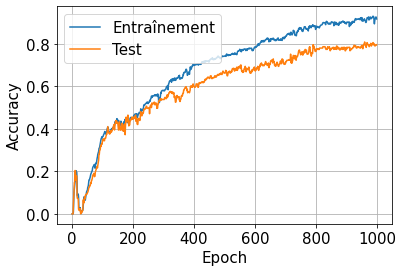

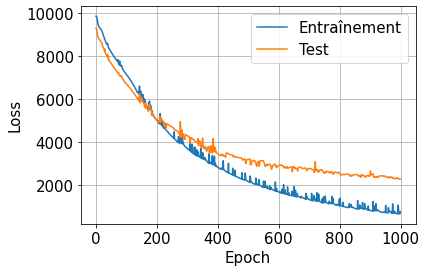

In [36]:
#  "Accuracy"
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.title('model accuracy')
plt.ylabel('Accuracy',fontsize = 15)
plt.xlabel('Epoch',fontsize = 15)
plt.legend(['Entraînement', 'Test'], loc='upper left',fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.savefig('accuracy.pdf',bbox_inches='tight')


plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('model loss')
plt.ylabel('Loss',fontsize = 15)
plt.xlabel('Epoch',fontsize = 15)
plt.legend(['Entraînement', 'Test'], loc='upper right',fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.savefig('loss.pdf',bbox_inches='tight')
plt.show()


Génération des données pour appliquer k-NN

In [69]:
X = np.array([autoenc.vectoriser(p) for p in phrasesSpacy ] +[autoenc.vectoriser(p) for p in phrases])
y = np.array([i % 157 for i in range(len(phrasesSpacy))]+[i % 157 for i in range(len(phrasesSpacy))])#les données d'origine sont 157 questiosn

In [70]:
np.shape(X)

(3140, 128)

L'algorithme K-NN optimisé par cross validation

In [71]:
# Training classifiers
from itertools import product

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

Voisins: 1
Score par cross_val 0.7117929870973363
Test accuray 0.7531847133757962


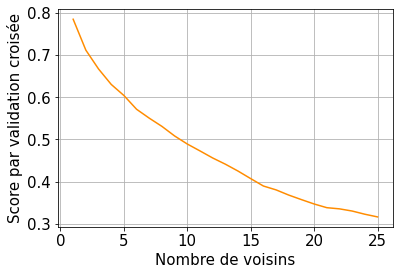

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Answer

k_values = np.arange(1, 26)

scores_cross_val =  []
accuracies = []

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train,y_train)
    predictions = clf.predict(X_test)
    rep = 0
    for i in range(len(predictions)):
        rep += (predictions[i] == y_test[i])
    scores_cross_val.append(np.mean(cross_val_score(clf, X_train, y_train)))
    accuracies.append(rep/len(predictions))


    
    
    
meilleur_k = np.argmax(scores_cross_val)+1
print("Voisins:",meilleur_k)
print("Score par cross_val", scores_cross_val[meilleur_k])
print("Test accuray", accuracies[meilleur_k])


plt.figure(3)
plt.plot(k_values,scores_cross_val,c='darkorange')
#plt.title('model loss')
plt.ylabel('Score par validation croisée',fontsize = 15)
plt.xlabel('Nombre de voisins',fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.savefig('cross_val_knn.pdf',bbox_inches='tight')
plt.show()

In [73]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X,y)

def Repondre(phrase):
    vect = autoenc.vectoriser(phrase)
    return(clf.predict([vect])[0])

In [81]:
Repondre("Qui approuve le règlement intérieur ?")

35

In [75]:
predictions = [Repondre(p) for p in phrasesSpacy]
print("Fréquence de bonne prédiction: ",sum([(y[i] == predictions[i]) for i  in range(len(phrases))])/len(phrases))

Fréquence de bonne prédiction:  0.9859872611464968
